In [175]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [176]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


## Prepare Dataset

In [177]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

# train_df_path = './dataset/train_all_socialab.csv'
train_df_path = './dataset/indo-nlu-socialabs-penelitian-merged-new-clean.csv'

# train_dataset_path = './dataset/train_preprocess_no_stemming copy.csv'
# valid_dataset_path = './dataset/valid_preprocess_no_stemming.csv'

In [178]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[1,2], skiprows=1)

# train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
# valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)

train_df.columns = ['label', 'tweet_tokens_no_stemming']
# valid_df.columns = ['label', 'tweet_tokens_no_stemming']

In [179]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mbri', 'hujah', '..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'sat', 'unboxing', 'pake..."
4,negative,"['duh', 'mahasiswa', 'jangan_sombong', 'kasih'..."
5,positive,"['makan', 'agam', 'harga', 'makan', 'fod', 'st..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak_un..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makan', 'enak'..."
8,positive,"['keluarga', 'nikmat', 'alam', 'kuliner', 'sen..."
9,positive,['syukur']


In [180]:
def get_label_idx(label):
    if label == 'positive':
        return 2
    if label == 'negative':
        return 1
    if label == 'neutral':
        return 0
train_df['label'] = train_df['label'].apply(get_label_idx)
# valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [181]:
train_df

,label,tweet_tokens_no_stemming
0,2,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,0,"['mohon', 'ulama', 'lurus', 'mbri', 'hujah', '..."
2,2,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,2,"['betapa', 'bahagia', 'sat', 'unboxing', 'pake..."
4,1,"['duh', 'mahasiswa', 'jangan_sombong', 'kasih'..."
...,...,...
43451,2,"['memoisturizer', 'cosrx', 'oil', 'fre', 'memo..."
43452,2,"['suka', 'memoisturizer', 'cosrx', 'harga', 'l..."
43453,2,"['lintang', 'kemari', 'pakai', 'hadalabo', 'me..."
43454,2,"['memoisturizer', 'baik', 'natrep', 'lacto', '..."


In [182]:
jumlah_positives = (train_df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (train_df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 21777
Jumlah review negatif: 19416


In [231]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet_tokens_no_stemming"].apply(join_text_list)
# valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

0    warung milik usaha pabrik puluh tahun-tahun ke...
1    mohon ulama lurus mbri hujah partai apa-apa di...
2    lokasi strategis jalan sumatera bandung nyaman...
3    betapa bahagia sat unboxing paket barang bagus...
4    duh mahasiswa jangan_sombong kasih kartu kunin...
Name: preprocessed, dtype: object

In [184]:
# df_preprocessed = pd.DataFrame(train_df['preprocessed'])

In [185]:
# df_preprocessed

# df_preprocessed.to_csv('./dataset/processed.csv', index=False)

In [186]:
# Filter DataFrame untuk label 1 dan 2
df_train_filtered = train_df[train_df['label'].isin([1, 2])]
# df_valid_filtered = valid_df[valid_df['label'].isin([1, 2])]

# Perbarui label sehingga label 1 menjadi 0 dan label 2 menjadi 1
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map({1: 0, 2: 1})
# df_valid_filtered.loc[:, 'label'] = df_valid_filtered['label'].map({1: 0, 2: 1})


# Split dataset menjadi fitur (X) dan label (y)
X_train = df_train_filtered['preprocessed']
y_train = df_train_filtered['label']

# X_valid = df_valid_filtered['preprocessed']
# y_valid = df_valid_filtered['label']

In [187]:
## hitung jumlah positive dan negative
jumlah_positives = (y_train == 1).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_train == 0).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

# jumlah_positives = (y_valid == 1).sum()
# print(f'Jumlah review positif: {jumlah_positives}')

# jumlah_negatives = (y_valid == 0).sum()
# print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 21777
Jumlah review negatif: 19416


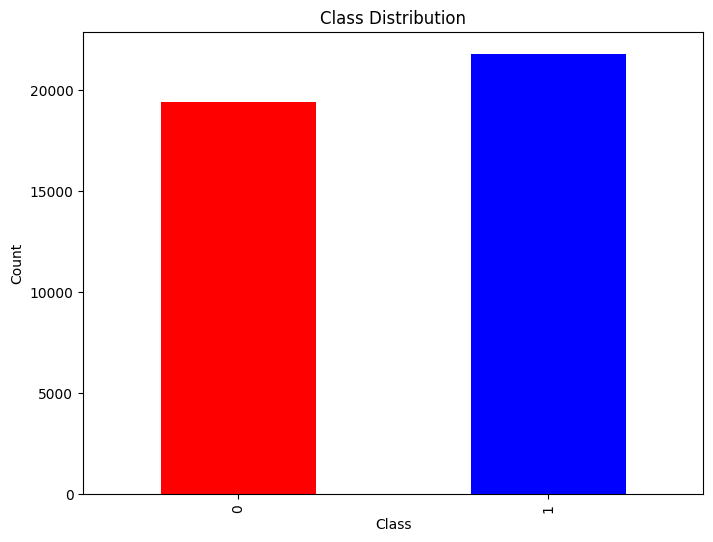

In [188]:
# Mengatur warna per kelas
colors = ['red', 'blue']

# Membuat grafik distribusi kelas dengan warna yang berbeda
plt.figure(figsize=(8, 6))
y_train.value_counts().sort_index().plot(kind='bar', color=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

In [224]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train,random_state=42)

## Generate Padded Sequence

In [225]:
# Parameters

vocab_size = 60000 #ukuran kosakata yang akan digunakan
max_length = 50 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

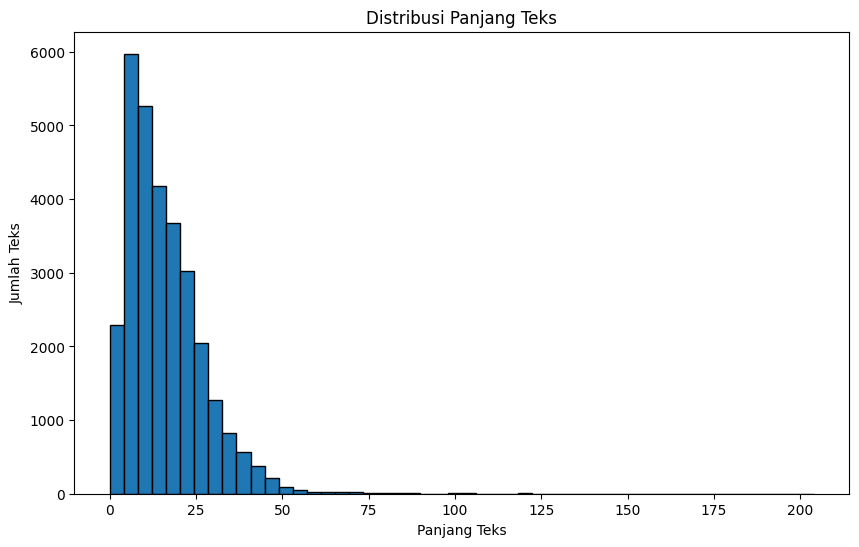

In [226]:
import matplotlib.pyplot as plt

# Misalkan texts adalah daftar teks dalam data training
text_lengths = [len(text.split()) for text in X_train]

# Plot distribusi panjang teks
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.xlabel('Panjang Teks')
plt.ylabel('Jumlah Teks')
plt.title('Distribusi Panjang Teks')
plt.show()


In [192]:
# import numpy as np

# # Menentukan panjang yang mencakup 95% teks
# max_length = int(np.percentile(text_lengths, 95))

# print(f"Max length yang mencakup 95% dari teks: {max_length}")


In [227]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Preprocess texts to retain underscore and tokenize specific punctuations
def preprocess_text(text):
    to_tokenize = '.,:;!?'
    return re.sub(r'([' + re.escape(to_tokenize) + '])', r' \1 ', text)

# Apply preprocessing
X_train = [preprocess_text(text) for text in X_train]
X_valid = [preprocess_text(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters='!"#$%&()*+-/:;<=>@[\\]^`{|}~\t\n')

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




In [228]:
word_index

{'<OOV>': 1,
 'makan': 2,
 'milu': 3,
 'orang': 4,
 'enak': 5,
 'banget': 6,
 'israel': 7,
 'the': 8,
 'kulit': 9,
 'harga': 10,
 'iya': 11,
 'pakai': 12,
 'palestina': 13,
 'politik': 14,
 'indonesia': 15,
 'apa': 16,
 'iran': 17,
 'suka': 18,
 'tahun': 19,
 'anak': 20,
 'wajah': 21,
 'baik': 22,
 'anies': 23,
 'pilih': 24,
 'bagus': 25,
 'coba': 26,
 'and': 27,
 'sat': 28,
 'produk': 29,
 'kuna': 30,
 'lihat': 31,
 'ganjar': 32,
 'sete': 33,
 'beli': 34,
 'bandung': 35,
 'menu': 36,
 'of': 37,
 'timnas': 38,
 'dukung': 39,
 'malam': 40,
 'pas': 41,
 'sehat': 42,
 'mai': 43,
 'gue': 44,
 'jalan': 45,
 'didi': 46,
 'is': 47,
 'kali': 48,
 'restoran': 49,
 'benar': 50,
 'cocok': 51,
 'rakyat': 52,
 'salah': 53,
 'asa': 54,
 'jerawat': 55,
 'bersih': 56,
 'toner': 57,
 'lumayan': 58,
 'murah': 59,
 'masuk': 60,
 'hasil': 61,
 'hinga': 62,
 'deh': 63,
 'kayak': 64,
 'suasana': 65,
 'besar': 66,
 'keluarga': 67,
 'nyaman': 68,
 'langsung': 69,
 'dolar': 70,
 'mahal': 71,
 'pimpin': 72,
 's

In [194]:
# save word index and term to csv
# df_word_index = pd.DataFrame.from_dict(word_index, orient='index')

In [195]:
# df_word_index

In [196]:
# df_word_index.to_csv('./word_index.csv', index=True)

In [197]:

# hitung rata rata panjang sequences
avg_sequence_length = np.mean([len(sequence) for sequence in train_sequences] + [len(sequence) for sequence in valid_sequences])
print(f"Average sequence length: {avg_sequence_length}")

Average sequence length: 16.521059403296675


In [198]:
# df_word_index = pd.DataFrame(word_index.items(), columns=['word', 'index'])

# # Periksa hasil tokenisasi
# print(df_word_index.head(20))

# # Simpan hasil tokenisasi ke file CSV
# df_word_index.to_csv('./dataset/word_index.csv', index=False, sep=',')

In [219]:
# import pickle

# # Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-stemmed-new.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [229]:
print(train_padded[3000])

[160 613  24  23   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Word Embedding

In [201]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [202]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [203]:
embedding_matrix.shape

(60000, 8)

In [204]:
# # save embedding matrix to csv
# df_embedding_matrix = pd.DataFrame(embedding_matrix)

# df_embedding_matrix.to_csv('./embedding_matrix.csv', index=False)

In [205]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[1000])
print(word)

('gambar', array([-1.07920063,  0.06842241,  0.81061465,  0.04057156,  0.92801797,
       -0.85765749,  0.60259891, -0.46505684]))


In [206]:
print(w2v_model.wv['oke'])

[-3.6984482  -3.7303755   2.0646408   2.8729236   1.2547356  -1.9529246
  0.31583485  0.8768617 ]


In [207]:
# # check jumlah kelas
jumlah_positives = (y_valid == 1).sum()

print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_valid == 0).sum()

print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 2178
Jumlah review negatif: 1942


## Build and Compile Model

In [208]:



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 50, 8)             │    480,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_17 (Conv1D)              │ (None, 50, 128)           │      5,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 25, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_29 (Dropout)            │ (None, 25, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_12 (Flatten)            │ (None, 3200)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_24 (Dense)                │ (None, 16)                │     51,216 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_30 (Dropout)            │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_25 (Dense)                │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 536,481 (2.05 MB)

 Trainable params: 536,481 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_12
Weights Shape (Tensor 0): (60000, 8)
Weights (Tensor 0):
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [-2.455228  -3.8813512  4.580259  ... -3.5384197  1.7226588 -1.0094047]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
Layer Name: conv1d_17
Weights Shape (Tensor 0): (5, 8, 128)
Weights (Tensor 0):
[[[ 0.02392171 -0.05312113  0.07635999 ...  0.01383781  0.09354602
    0.02375491]
  [-0.05413014 -0.0541997   0.03239766 ... -0.08845066 -0.04722437
   -0.0475259 ]
  [-0.0666307  -0.00103886 -0.02239987 ... -0.01368797 -0.05351198
   -0.08868131]
  ...
  [ 0.00963353  0.09099309  0.03654507 ...  0.01617981  0.03647956
    0.05039831]
  [ 0.03538312 -0.08252531 -0.0818433  ...  0.01200942 -

## Train Model

In [210]:
num_epochs = 20
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_padded, y_train, batch_size=128, epochs=num_epochs, validation_data=(valid_padded, y_valid), callbacks=[lr_schedule, early_stopping])


Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6213 - loss: 0.6508 - val_accuracy: 0.7748 - val_loss: 0.5054 - learning_rate: 1.0000e-04
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7494 - loss: 0.5267 - val_accuracy: 0.7789 - val_loss: 0.4818 - learning_rate: 1.1220e-04
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7702 - loss: 0.4994 - val_accuracy: 0.7823 - val_loss: 0.4675 - learning_rate: 1.2589e-04
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7788 - loss: 0.4847 - val_accuracy: 0.7867 - val_loss: 0.4608 - learning_rate: 1.4125e-04
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7795 - loss: 0.4884 - val_accuracy: 0.7908 - val_loss: 0.4533 - learning_rate: 1.5849e-04
Epoch 6/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7874 - loss: 0.4729 - val_accuracy: 0.7913 - val_loss: 0.4482 - learning_rate: 1.7783e-04
Epoch 7/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - a

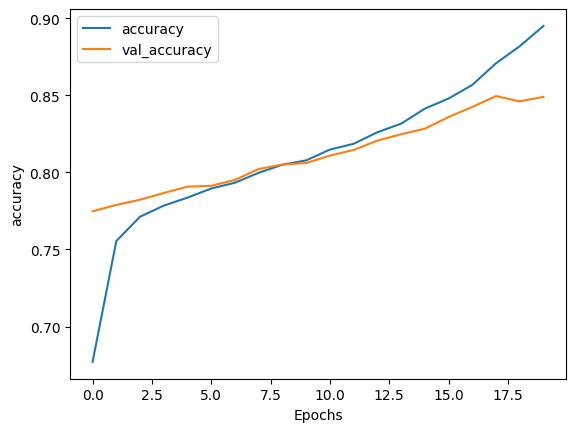

In [211]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

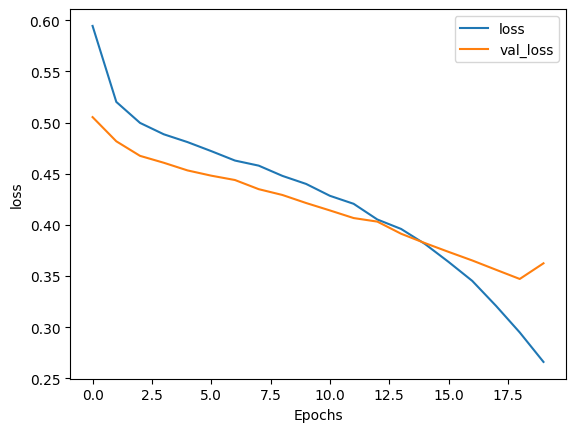

In [212]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [213]:
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Menggunakan fungsi untuk memprediksi sentimen dari contoh kalimat
sample_text = "pakai toner ini bikin kulit jadi kering banget, tidak_cocok buat kulitku"
predicted_label = predict_sentiment(model, tokenizer, sample_text)
print("Label Sentimen:", predicted_label)
   


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
[[0.19449644]]
Label Sentimen: Negatif


In [214]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = (y_pred >= 0.5).astype(int)

# Mencetak classification report
# print(classification_report(df_valid_filtered["label"], y_pred_classes))
print(classification_report(y_valid, y_pred_classes))

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1942
           1       0.86      0.84      0.85      2178

    accuracy                           0.85      4120
   macro avg       0.85      0.85      0.85      4120
weighted avg       0.85      0.85      0.85      4120



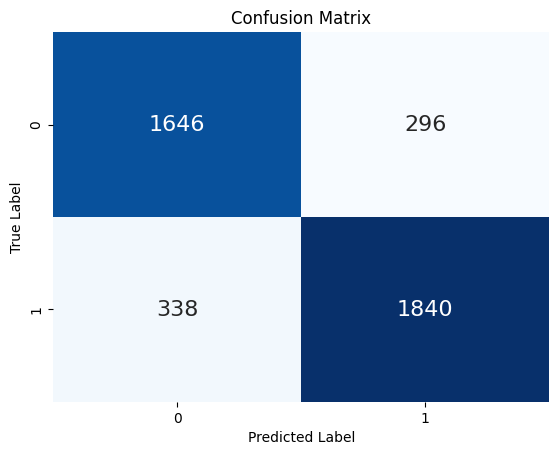

In [215]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
# cm = confusion_matrix(df_valid_filtered["label"], y_pred_classes)
cm = confusion_matrix(y_valid, y_pred_classes)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [216]:
print(cm)

[[1646  296]
 [ 338 1840]]


In [217]:
# Asumsi model dan tokenizer sudah didefinisikan
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Kalimat contoh untuk pengujian
test_sentences = [
    "Pada awalnya saya ragu dengan kemampuan perusahaan ini, namun setelah melihat kinerja mereka selama beberapa bulan terakhir, saya sangat puas dengan hasil yang mereka capai.",
    "Film ini memulai dengan sangat membosankan dan lambat, tetapi akhir ceritanya sangat mengharukan dan membuat saya terkesan.",
    "Meskipun layanan pelanggan mereka sangat lambat dan kurang responsif, kualitas produk yang mereka tawarkan sangatlah bagus.",
    "Restoran ini memiliki makanan yang lezat, tetapi pelayanannya sangat buruk dan membuat pengalaman makan saya tidak menyenangkan.",
    "Saya mengalami banyak masalah dengan perangkat ini di awal, namun setelah pembaruan terbaru, kinerjanya menjadi jauh lebih baik.",
    "Aplikasi ini sering mengalami crash pada versi awal, tetapi sekarang setelah beberapa pembaruan, aplikasinya sangat stabil dan berguna.",
    "Hotel ini memiliki pemandangan yang luar biasa dan staf yang ramah, meskipun kamarnya cukup kotor pada saat saya tiba.",
    "Buku ini dimulai dengan alur yang sangat lambat, namun karakter dan ceritanya berkembang dengan sangat baik menjelang akhir.",
    "Konser ini awalnya terasa membosankan, tetapi penampilan penutupnya sangat spektakuler dan membuat semuanya terbayar.",
    "Saya awalnya kecewa dengan kualitas pakaian ini, tetapi setelah beberapa kali dicuci, kualitas bahannya ternyata sangat tahan lama.",
    "Saya tidak masalah sama sekali gaji dipotong tiap bulan untuk BPJS Kesehatan. Semisal jarang pakai pun, anggap saja sedekah dan membantu sesama.  Tapi untuk TAPERA ini, jelas saya tidak ikhlas. Subsidi silang buat yang tidak mampu? Ah tidak juga rasanya.  Kebijakan aneh.",
    "Kebijakan pemerintah tentang kenaikan harga BBM sangat memberatkan masyarakat kecil.",
    "Reformasi pajak yang diusulkan akan sangat membantu meningkatkan perekonomian negara.",
    "Keputusan untuk memperpanjang masa jabatan presiden sangat kontroversial dan memicu banyak protes.",
    "Program bantuan sosial yang baru diluncurkan sangat membantu masyarakat miskin.",
    "Pemilihan umum kali ini sangat penting untuk masa depan negara kita.",
    "Banyak yang kecewa dengan hasil debat politik semalam, banyak janji yang tidak realistis.",
    "Tindakan korupsi yang dilakukan oleh pejabat tinggi harus ditindak tegas.",
    "Perubahan undang-undang ini sangat penting untuk melindungi hak-hak pekerja.",
    "Diskusi tentang kebijakan luar negeri semakin memanas, banyak pihak yang berbeda pendapat.",
    "Partai oposisi mengkritik keras kebijakan ekonomi pemerintah yang dianggap tidak efektif.",
    "Rencana pembangunan infrastruktur baru di wilayah timur sangat disambut baik oleh masyarakat."
]
   
# Memprediksi sentimen untuk setiap kalimat dan menyimpan hasil ke DataFrame
results = []

for sentence in test_sentences:
    predicted_label = predict_sentiment(model, tokenizer, sentence)
    results.append({"Teks": sentence, "Label Sentimen": predicted_label})

# Membuat DataFrame
df = pd.DataFrame(results)

# Menyimpan DataFrame ke file CSV
# df.to_csv('prediksi_sentimen-cnn.csv', index=False)

df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[[0.8833915]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.74010134]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.70279115]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.7387146]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.7894447]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0.71980405]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[0.8674133]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.8351442]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.8689245]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.84371746]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.43730757]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[0.905308]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[0.25262538]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.63651264]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.9196656]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.7605485]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.09947138]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.24978337]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.7935741]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.

,Teks,Label Sentimen
0,Pada awalnya saya ragu dengan kemampuan perusa...,Positif
1,Film ini memulai dengan sangat membosankan dan...,Positif
2,Meskipun layanan pelanggan mereka sangat lamba...,Positif
3,"Restoran ini memiliki makanan yang lezat, teta...",Positif
4,Saya mengalami banyak masalah dengan perangkat...,Positif
5,Aplikasi ini sering mengalami crash pada versi...,Positif
6,Hotel ini memiliki pemandangan yang luar biasa...,Positif
7,Buku ini dimulai dengan alur yang sangat lamba...,Positif
8,"Konser ini awalnya terasa membosankan, tetapi ...",Positif
9,Saya awalnya kecewa dengan kualitas pakaian in...,Positif


In [218]:
#save model
# model.save('./model/model-cnn-word2vec-2-classes-stemmed-new-32.h5')
# model.save('./model/model-cnn-word2vec-2-classes-stemmed-new.h5')

In [1124]:
32# import numpy as np
# import tensorflow as tf

# # Inisialisasi bobot kernel dengan ukuran 5
# kernel_size = 5
# num_filters = 1
# embedding_dim = 8

# # Membuat bobot kernel dengan inisialisasi Glorot uniform
# initializer = tf.keras.initializers.GlorotUniform()
# kernel_weights = initializer(shape=(kernel_size, embedding_dim, num_filters))

# # Dibulatkan ke angka terdekat
# kernel_weights_rounded = np.round(kernel_weights, decimals=2)

# print("Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):")
# print(kernel_weights_rounded)
# print("Shape bobot kernel:", kernel_weights.shape)
